<h2>HUXt examples.</h2>

This notebook contains several examples of how to use the HUXt, as described in Owens et al (2020).

In [1]:
import numpy as np
import astropy.units as u
from astropy.time import Time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import huxt as H
import huxt_analysis as HA
import huxt_inputs as Hin

Run HUXt in 1D (along one longitude) with user specified V boundary conditions and no CMEs

No initiation time specified. Defaulting to 1977-9-27


(<Figure size 1008x504 with 1 Axes>,
 <AxesSubplot:title={'center':'HUXt Radius: 214.50$R_{sun}$  Longitude: 0.02$^\\circ$'}, xlabel='Time (days)', ylabel='Solar Wind Speed (km/s)'>)

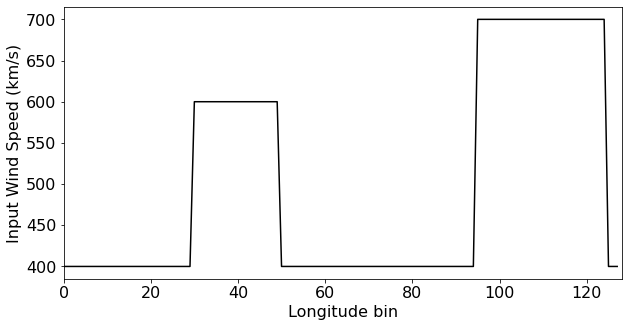

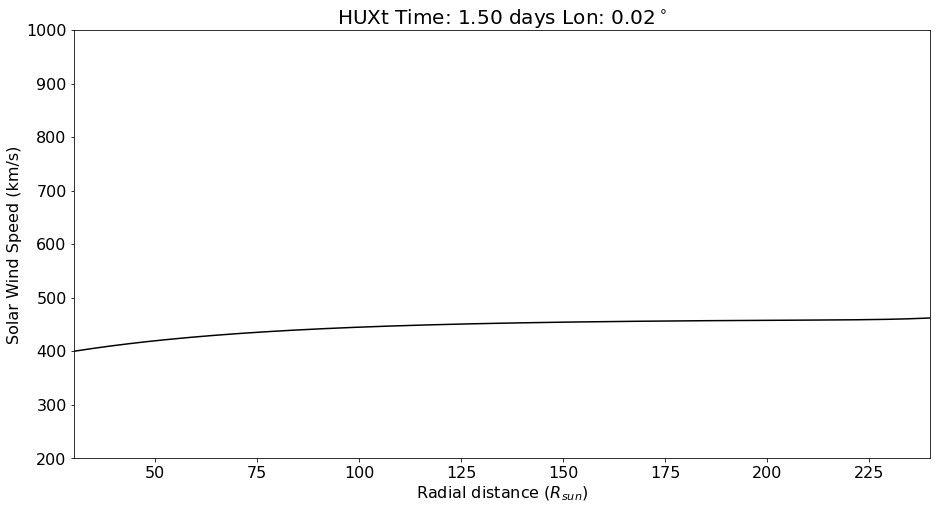

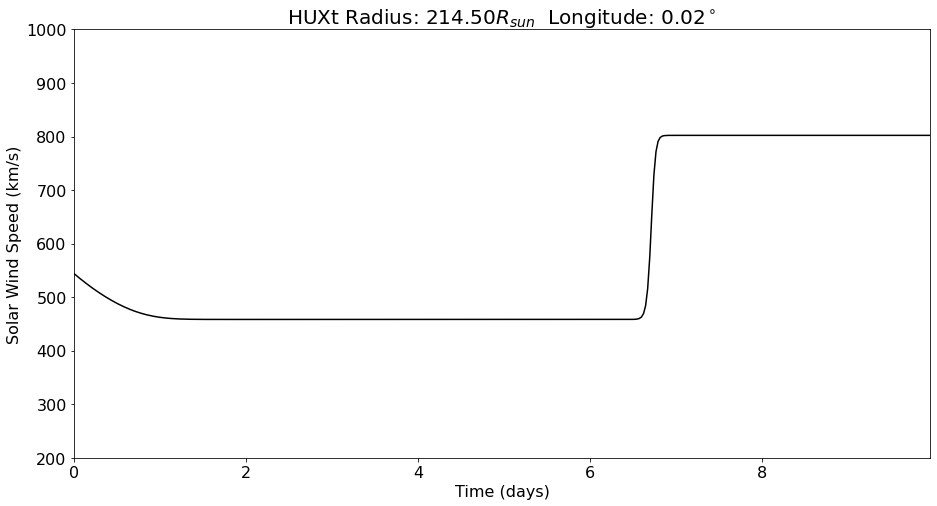

In [2]:
#Form longitudinal boundary conditions - background wind of 400 km/s with two fast streams.
v_boundary = np.ones(128) * 400 * (u.km/u.s)
v_boundary[30:50] = 600 * (u.km/u.s)
v_boundary[95:125] = 700 * (u.km/u.s)

# This boundary condition looks like
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(v_boundary,'k-')
ax.set_xlabel('Longitude bin')
ax.set_ylabel('Input Wind Speed (km/s)')
ax.set_xlim(0,128)

# Setup HUXt to do a 5 day simulation, with model output every 4 timesteps (roughly half and hour time step), looking at 0 longitude
model = H.HUXt(v_boundary=v_boundary, lon_out=0.0*u.deg, simtime=10*u.day, dt_scale=4)

# Solve these conditions, with no ConeCMEs added.
cme_list = []
model.solve(cme_list)

# Plot the radial profile of the ambient wind profile at a fixed time (in days). 
t = 1.5*u.day
HA.plot_radial(model, t, lon=0.0)

# Plot the time series of the ambient wind profile at a fixed radius. 
r = 1.0*u.AU
HA.plot_timeseries(model, r, lon=0.0)

Run HUXt in 1D (along one longitude) with user specified boundary conditions and single Cone CME

No initiation time specified. Defaulting to 1977-9-27


(<Figure size 1008x504 with 1 Axes>,
 <AxesSubplot:title={'center':'HUXt Radius: 214.50$R_{sun}$  Longitude: 0.02$^\\circ$'}, xlabel='Time (days)', ylabel='Solar Wind Speed (km/s)'>)

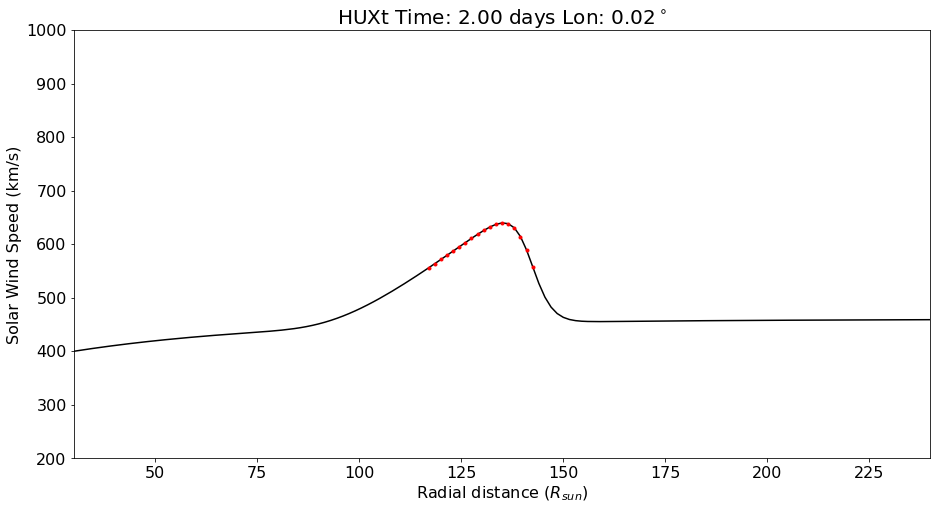

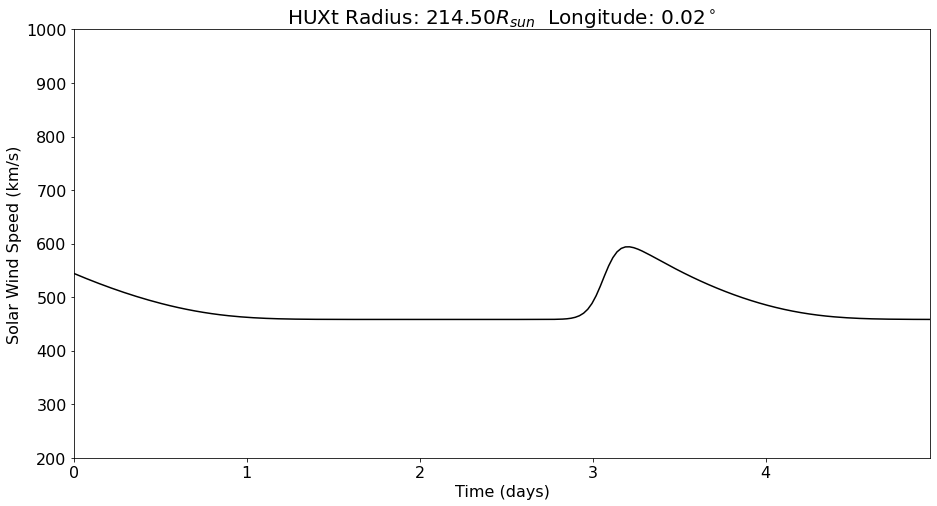

In [3]:
# Set up a ConeCME that launches half a day after the simulation begins, at 0 longitude, 30 degree width, speed 850km/s and thickness=5 solar radii
cme = H.ConeCME(t_launch=0.5*u.day, longitude=0.0*u.deg, width=30*u.deg, v=850*(u.km/u.s), thickness=5*u.solRad)
cme_list = [cme]

# Setup HUXt to do a 5 day simulation, with model output every 4 timesteps (roughly half and hour time step), looking at 0 longitude
model = H.HUXt(v_boundary=v_boundary, lon_out=0.0*u.deg, simtime=5*u.day, dt_scale=4)

# Run the model, and this time save the results to file.
model.solve(cme_list, save=True, tag='1d_conecme_test')

# Plot the radial profile and time series of both the ambient and ConeCME solutions at a fixed time (in days). 
# Save both to file as well. These are saved in HUXt>figures>HUXt1D
t = 2*u.day
HA.plot_radial(model, t, lon=0.0*u.deg, save=True)

r = 1.0*u.AU
HA.plot_timeseries(model, r, lon=0.0*u.deg, tag='1d_cone_test_radial')

Now run HUXt using boundary conditions taken from HelioMAS output.

Files already exist for CR2054


(<Figure size 1008x504 with 1 Axes>,
 <AxesSubplot:title={'center':'HUXt Radius: 214.50$R_{sun}$  Longitude: 0.02$^\\circ$'}, xlabel='Time (days)', ylabel='Solar Wind Speed (km/s)'>)

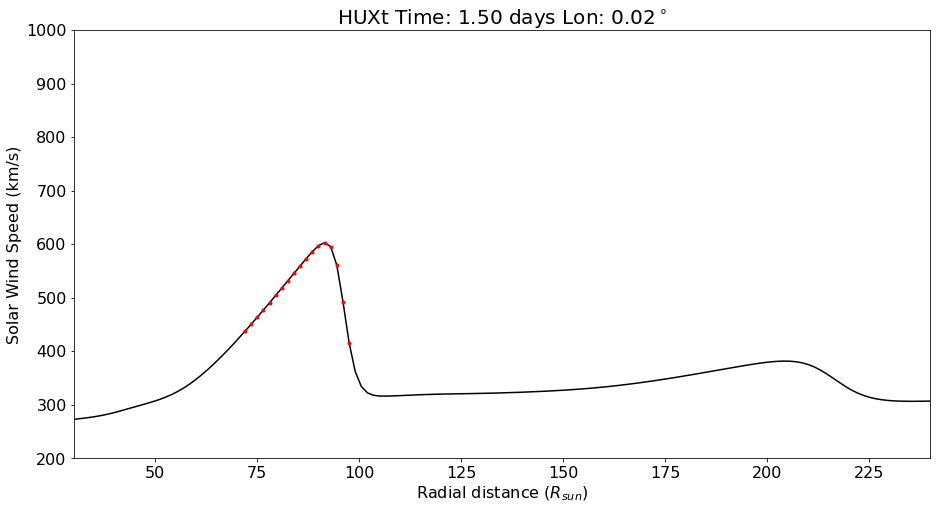

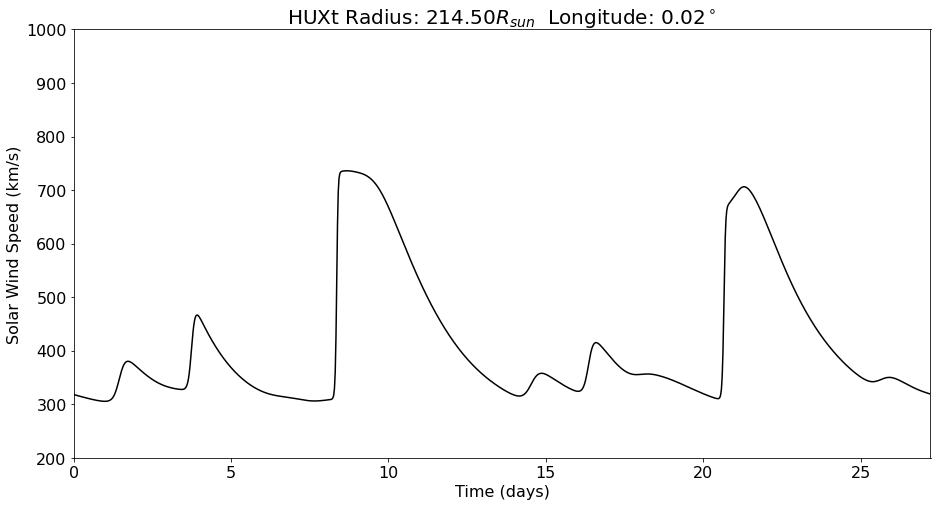

In [4]:
#HUXt can be initiated MAS, by specifying a carrington rotation number
cr = 2054
vr_in = Hin.get_MAS_long_profile(cr, 0.0*u.deg)

model = H.HUXt(v_boundary=vr_in, cr_num=cr, lon_out=0.0*u.deg, simtime=27.27*u.day, dt_scale=4)

# Solve these conditions with a ConeCME.
cme = H.ConeCME(t_launch=0.5*u.day, longitude=0.0*u.deg, width=30*u.deg, v=1000*(u.km/u.s), thickness=10*u.solRad)
cme_list = [cme]
model.solve(cme_list)

# Plot the radial profile of the ambient wind solution at a fixed time (in days). 
t = 1.5*u.day
HA.plot_radial(model, t, lon=0.0*u.deg)

# Plot the time series of the ambient wind solution at a fixed radius. 
r = 1.0*u.AU
HA.plot_timeseries(model, r, lon=0.0*u.deg)


HUXt can also be run over multiple longitudes. Here HUXt is run over all longitudes, with user specified boundary conditions and a single CME

No initiation time specified. Defaulting to 1977-9-27


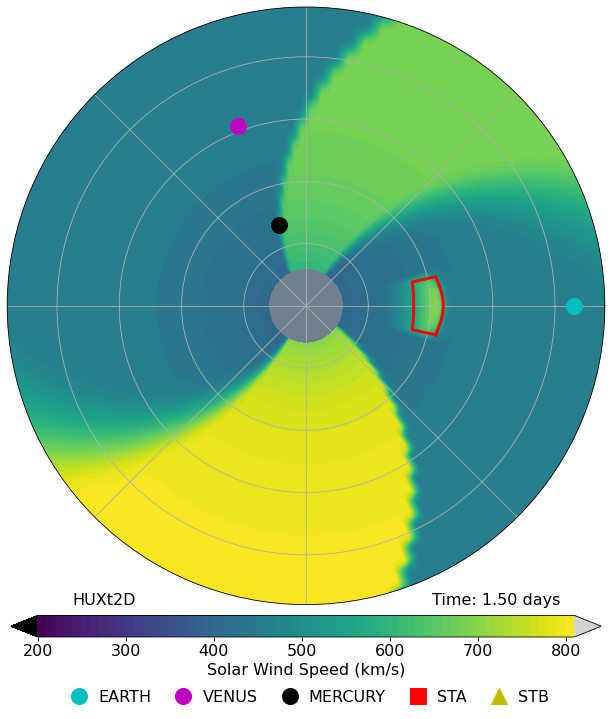

In [5]:
#  Form boundary conditions - background wind of 400 km/s with two fast streams.
v_boundary = np.ones(128) * 400 * (u.km/u.s)
v_boundary[30:50] = 600 * (u.km/u.s)
v_boundary[95:125] = 700 * (u.km/u.s)

#  Add a CME
cme = H.ConeCME(t_launch=0.5*u.day, longitude=0.0*u.deg, width=30*u.deg, v=1000*(u.km/u.s), thickness=5*u.solRad)
cme_list = [cme]

#  Setup HUXt to do a 5 day simulation, with model output every 4 timesteps (roughly half and hour time step)
model = H.HUXt(v_boundary=v_boundary, simtime=5*u.day, dt_scale=4)

model.solve(cme_list)

# Plot this out
t_interest = 1.5*u.day
fig, ax = HA.plot(model, t_interest)

There is also a function to animate these data. They are saved in HUXt>Figures

In [6]:
HA.animate(model, tag='cone_cme_test') # This takes about two minutes.

t:   0%|                                                                             | 0/240 [00:00<?, ?it/s, now=None]

Moviepy - Building video C:\Users\yq904481\research\repos\HUXt\figures\HUXt_CR1659_cone_cme_test_movie.mp4.
Moviepy - Writing video C:\Users\yq904481\research\repos\HUXt\figures\HUXt_CR1659_cone_cme_test_movie.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\yq904481\research\repos\HUXt\figures\HUXt_CR1659_cone_cme_test_movie.mp4


HUXt results can be saved to a HDF5 file, either automatically in the solve method, or by a separate save method. There is also a load function. 

In [7]:
out_path = model.save(tag='cone_cme_test')
# And loaded back in with
model2, cme_list2 = H.load_HUXt_run(out_path)

CMEs are trackd through the HUXt domain using test particles that advect with the flow. These coordinates are accessible via the ConeCME objects.

Text(0, 0.5, 'Y ($R_{sun}$)')

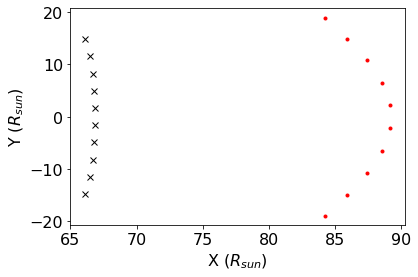

In [8]:
cme = model.cmes[0]
timestep = 50
r = cme.coords[timestep]['r'].to(u.solRad)
lon = cme.coords[timestep]['lon']
x = r * np.cos(lon)
y = r * np.sin(lon)

# There is also a "front_id" field to separate the nose and rear.
id_front = cme.coords[timestep]['front_id'] == 1.0
id_back = cme.coords[timestep]['front_id'] == 0.0

fig, ax = plt.subplots() # compare this with the boundary in the frame above.
ax.plot(x[id_front] , y[id_front] , 'r.')
ax.plot(x[id_back] , y[id_back] , 'kx')
ax.set_xlabel('X ($R_{sun}$)')
ax.set_ylabel('Y ($R_{sun}$)')

Multiple Cone CMEs can be inserted into HUXt in any run. Also, functions are provided to download inner boundary conditions from the HelioMAS model. Below we set up HUXt to run for Carrington rotation 2100, retrieving the boundary condition from Predictive Science (unless it is already downloaded). Then three Cone CMEs are inserted, and the output animated.

In [9]:
#  Get inner boundary condition from Carrington rotation 2100
cr=2100
vr_in = Hin.get_MAS_long_profile(cr, 0.0*u.deg)
#  Setup HUXt to do a 5 day simulation, with model output every 4 timesteps (roughly half and hour time step).
model = H.HUXt(v_boundary=vr_in, cr_num=cr, simtime=5*u.day, dt_scale=4)

# Produce a list of ConeCMEs to pass to HUXt
daysec = 86400
times = [0.5*daysec, 1.5*daysec, 3*daysec]
speeds = [850, 1000, 700]
lons = [0, 90, 300]
widths = [30, 40, 20]
thickness = [5, 4, 2]
cme_list = []
for t, l, w, v, thick in zip(times, lons, widths, speeds, thickness):
    cme = H.ConeCME(t_launch=t*u.s, longitude=l*u.deg, width=w*u.deg, v=v*model.kms, thickness=thick*u.solRad)
    cme_list.append(cme)

model.solve(cme_list, save=True, tag='multi_cones') # This takes a minute or so to run. 
HA.plot(model, 3.5*u.day)
HA.animate(model, tag='multi_cones')

Files already exist for CR2100


t:   0%|                                                                             | 0/240 [00:00<?, ?it/s, now=None]

Moviepy - Building video C:\Users\yq904481\research\repos\HUXt\figures\HUXt_CR2100_multi_cones_movie.mp4.
Moviepy - Writing video C:\Users\yq904481\research\repos\HUXt\figures\HUXt_CR2100_multi_cones_movie.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\yq904481\research\repos\HUXt\figures\HUXt_CR2100_multi_cones_movie.mp4


There is also an ephemeris of the HEEQ, HAE, and Carrington coordiates of Earth, Mercury, Venus, STEREO-A and STEREO-B

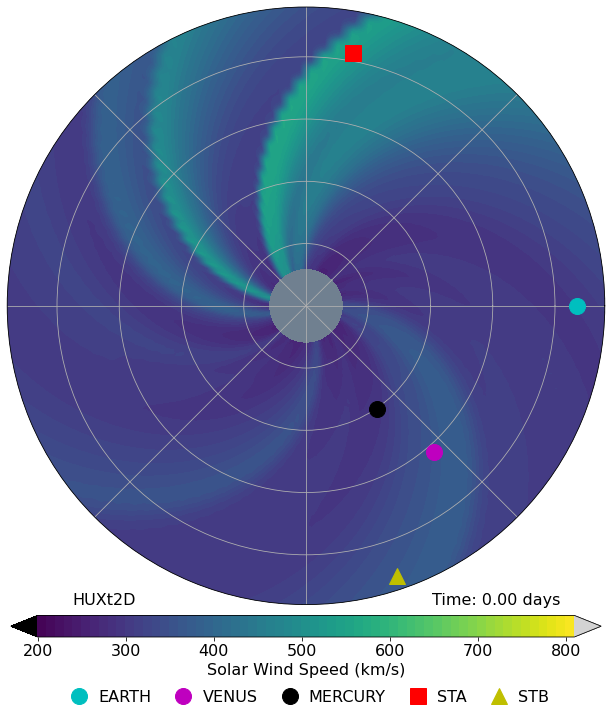

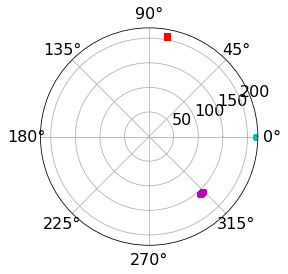

In [10]:
# These are automatically plotted on model solutions derived from a particular Carrington rotation.
HA.plot(model, model.time_out[0])

# You can retrieve a bodies position at each model timestep like:
earth = model.get_observer('earth')
sta = model.get_observer('sta')
venus = model.get_observer('venus')

# The bodies HEEQ and Carrington coordinates are attributes.
# So to plot them:
fig, ax = plt.subplots(subplot_kw={"projection": "polar"})
ax.plot(earth.lon, earth.r, 'co')
ax.plot(sta.lon, sta.r, 'rs')
ax.plot(venus.lon, venus.r, 'mo')

A function is provided to lookup the solar wind speed time series at Earth

Text(0, 0.5, 'Solar Wind Speed (km/s)')

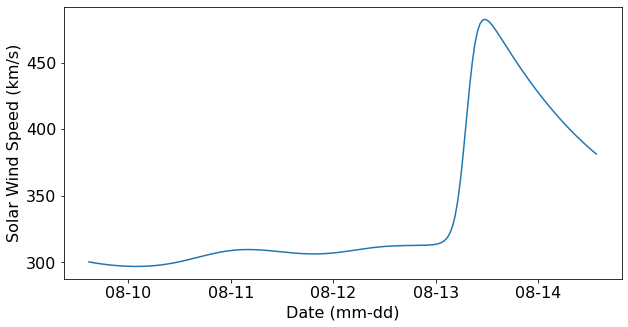

In [11]:
# Lookup Earth time series.
earth_series = HA.get_earth_timeseries(model)

# Plot this out and format the dates. 
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(earth_series['time'], earth_series['vsw'])
myFmt = mdates.DateFormatter('%m-%d')
ax.xaxis.set_major_formatter(myFmt)
ax.set_xlabel('Date (mm-dd)')
ax.set_ylabel('Solar Wind Speed (km/s)')



HUXt can also be run over a limited range of longitudes. As HUXt is a purely radial model, it can be run over any set of longitudes. This could save disk-space and runtime if you are interested in large ensembles. This is done with the `lon_start` and `lon_stop` arguments.


Files already exist for CR2120


(<Figure size 720x720 with 2 Axes>, <PolarAxesSubplot:>)

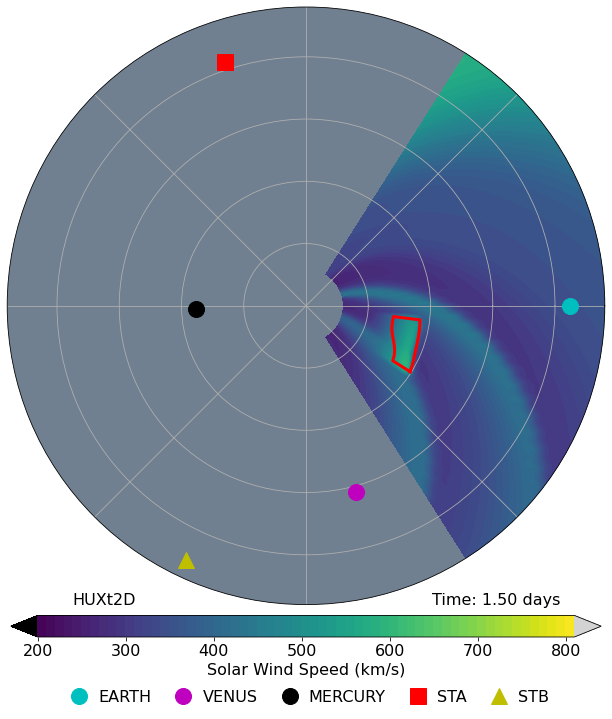

In [12]:
# Set up HUXt over a limited longitude range.
cr=2120
vr_in = Hin.get_MAS_long_profile(cr,0.0*u.deg)
model = H.HUXt(v_boundary=vr_in, cr_num=cr, lon_start=300*u.deg, lon_stop=60*u.deg, simtime=5*u.day, dt_scale=4)

# Get a list of two ConeCMEs
daysec = 86400
times = [0.5*daysec, 2*daysec]
speeds = [1000, 850]
lons = [-20, 20]
widths = [30, 30]
thickness = [8, 4]
cme_list = []
for t, l, w, v, thick in zip(times, lons, widths, speeds, thickness):
    cme = H.ConeCME(t_launch=t*u.s, longitude=l*u.deg, width=w*u.deg, v=v*model.kms, thickness=thick*u.solRad)
    cme_list.append(cme)

model.solve(cme_list, save=True, tag='multi_cones') # This takes a minute or so to run. 

t_interest = 1.5*u.day
HA.plot(model, t_interest)

The initial carrington longitude of Earth can be specified with the `cr_lon_init` argument. This sets the `time_init` attribute, so model times can be converted to UTC.

Files already exist for CR2120
360.0 deg 2012-02-06T06:42:33.508
270.0 deg 2012-02-13T02:45:10.629
180.0 deg 2012-02-19T22:47:12.384


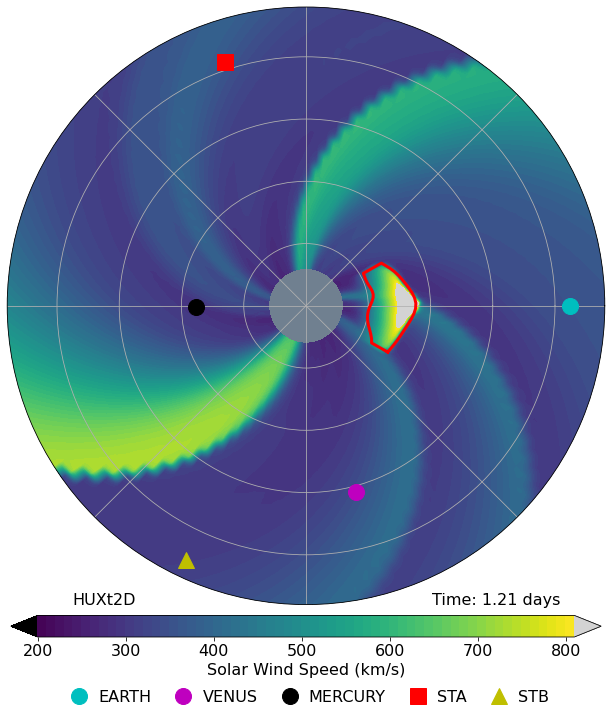

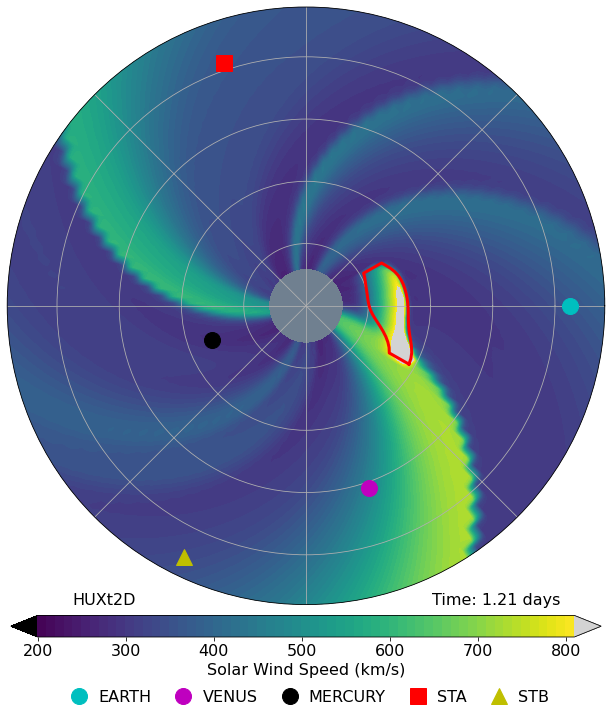

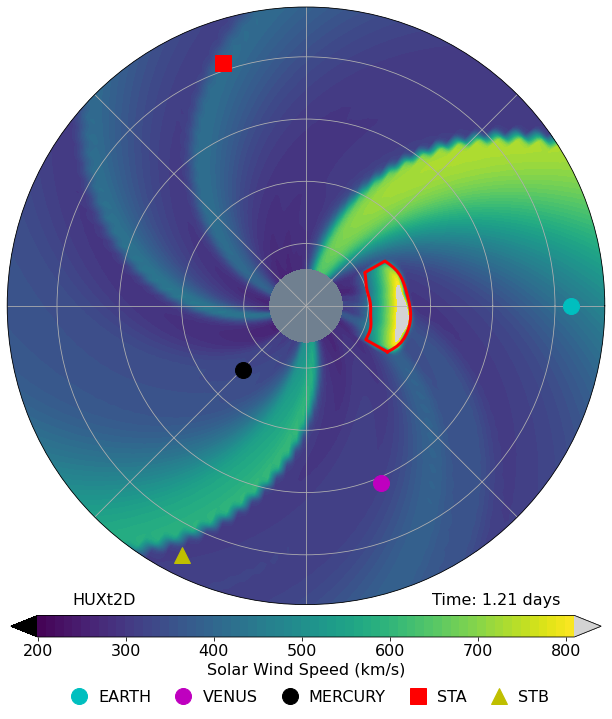

In [13]:
cr=2120
vr_in = Hin.get_MAS_long_profile(cr,0.0*u.deg)

for cr_lon in [360, 270, 180]:
    model = H.HUXt(v_boundary=vr_in, cr_num=cr, cr_lon_init=cr_lon*u.deg, simtime=5*u.day, dt_scale=4)
    cme = H.ConeCME(t_launch=0.5*u.day, longitude=0.0*u.deg, width=60*u.deg, v=1000*(u.km/u.s), thickness=5*u.solRad)
    model.solve([cme])
    cr_tag = 'cr_lon_{:03d}'.format(np.int32(cr_lon))
    HA.plot(model, model.time_out[50], save=True, tag=cr_tag)
    print(model.cr_lon_init.to('deg'), model.time_init.isot)


HUXt can be run with two rerfernce frames - the inner boundary is rotated with either the mean sidreal rotation rate, or with the synodic rotation rate from Earth's perspective. This is set with the `frame` argument. This doesn't always have a large effect on the solution, but can be worth considering. For example, in highly structured solar wind it can affect the CME arrival time by a few hours. 

Files already exist for CR2120
Adjusting CME HEEQ longitude for sidereal frame


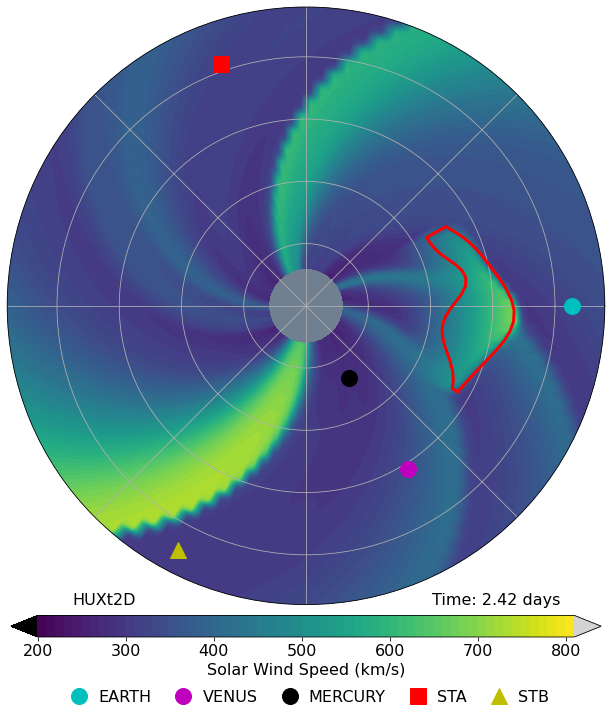

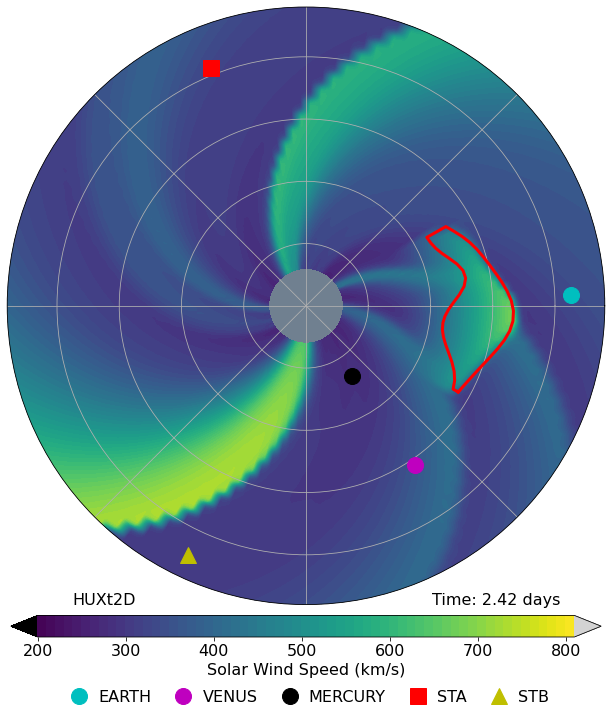

In [14]:
cr=2120
vr_in = Hin.get_MAS_long_profile(cr,0.0*u.deg)

# Synodic
model = H.HUXt(v_boundary=vr_in, cr_num=cr, cr_lon_init=0*u.deg, simtime=5*u.day, dt_scale=4, frame='synodic')
cme = H.ConeCME(t_launch=0.5*u.day, longitude=0.0*u.deg, width=60*u.deg, v=1000*(u.km/u.s), thickness=5*u.solRad)
model.solve([cme])
fig, ax = HA.plot(model, model.time_out[100], save=True, tag='synodic')

# Sidereal
model = H.HUXt(v_boundary=vr_in, cr_num=cr, cr_lon_init=0*u.deg, simtime=5*u.day, dt_scale=4, frame='sidereal')
cme = H.ConeCME(t_launch=0.5*u.day, longitude=0.0*u.deg, width=60*u.deg, v=1000*(u.km/u.s), thickness=5*u.solRad)
model.solve([cme])
fig, ax = HA.plot(model, model.time_out[100], save=True, tag='sidereal')

A function is included to compute the arrival time of CMEs at the solar system bodies available in the Observer class - Mercury, Venus, Earth, STEREO-A and STEREO-B. We will use this to show how the different synoidc and sidereal frames can affect the CMEs arrival time. In this instance the CME is strongly affected by a high speed stream, and the CME arrival time at Earth is about 4 hours different for the synodic and sidereal frames. 

Files already exist for CR2056
Adjusting CME HEEQ longitude for sidereal frame
**************************************
sidereal: Earth arrival:2007-05-27T14:18:58.074,  Transit time:2.14 d days, Arrival longitude:0.04 rad
**************************************
synodic: Earth arrival:2007-05-27T18:39:46.745,  Transit time:2.32 d days, Arrival longitude:0.00 rad


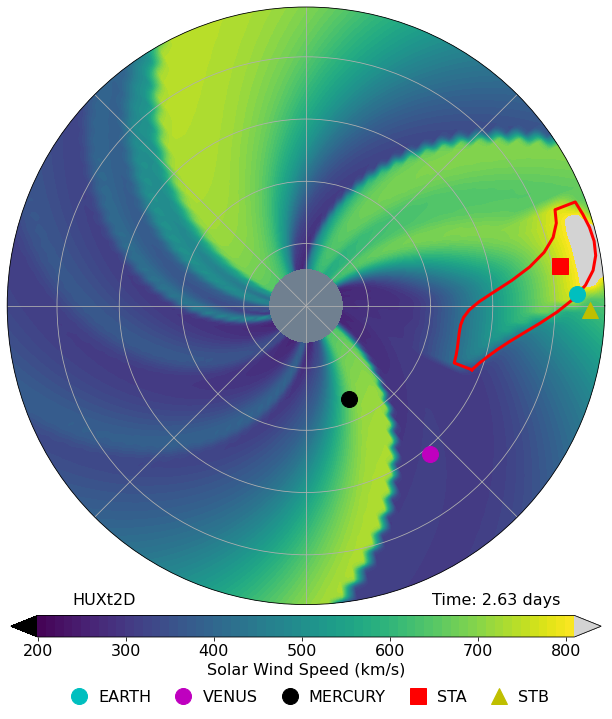

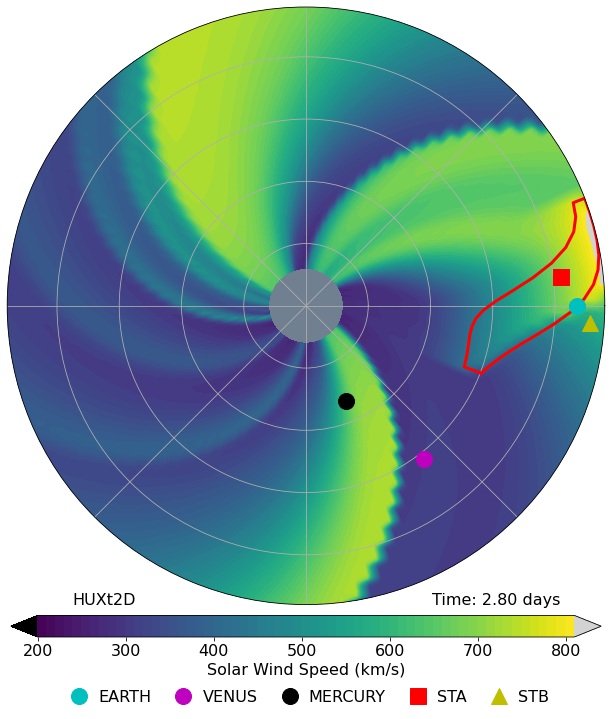

In [15]:
cr=2056
vr_in = Hin.get_MAS_long_profile(cr, 0.0*u.deg)

#  Synodic
for frame in ['sidereal', 'synodic']:
    model = H.HUXt(v_boundary=vr_in, cr_num=cr, cr_lon_init=0*u.deg, simtime=5*u.day, dt_scale=4, frame=frame)
    cme = H.ConeCME(t_launch=0.5*u.day, longitude=0.0*u.deg, width=45*u.deg, v=1000*(u.km/u.s), thickness=5*u.solRad)
    model.solve([cme])
    cme = model.cmes[0]
    hit, t_arrive, t_transit, hit_lon, hit_id = cme.compute_arrival_at_body('EARTH')
    
    #  Plot the solution at the nearest time step to impact.
    HA.plot(model, model.time_out[hit_id])
    
    #  Print out some arrival stats
    print("**************************************")
    print("{}: Earth arrival:{},  Transit time:{:3.2f} days, Arrival longitude:{:3.2f}".format(frame, t_arrive.isot, t_transit, hit_lon))


Most of the model parameters are attributes of the HUXt class and so can be accessed like:

In [16]:
# Model time step from the CFL condition:
print(model.dt)
# Output model time step
print(model.dt_out)
# A list of all attributes is in the documentation
help(model)

521.775 s
2087.1 s
Help on HUXt in module huxt object:

class HUXt(builtins.object)
 |  HUXt(v_boundary=<Quantity nan km / s>, cr_num=nan, cr_lon_init=<Quantity 360. deg>, latitude=<Quantity 0. deg>, r_min=<Quantity 30. solRad>, r_max=<Quantity 240. solRad>, lon_out=<Quantity nan rad>, lon_start=<Quantity nan rad>, lon_stop=<Quantity nan rad>, simtime=<Quantity 5. d>, dt_scale=1.0, frame='synodic')
 |  
 |  A class containing the HUXt model described in Owens et al. (2020, DOI: 10.1007/s11207-020-01605-3)
 |  
 |  Users must specify the solar wind speed boundary condition through either the v_boundary, or cr_num keyword
 |  arguments. Failure to do so defaults to a 400 km/s boundary. v_boundary takes precedence over cr_num, so specifying
 |  both results in only v_boundary being used.
 |  
 |  Model coordinate system is HEEQ radius and longitude.
 |  
 |  Attributes:
 |      cmes: A list of ConeCME instances used in the model solution.
 |      cr_num: If provided, this gives the Carrin

The inner boundary of HUXt defaults to 30Rs. But it can be specified by the user. To use the HelioMAS solutions with lower inner boundary heights, a function is provided to give an approximate mapping between the 30Rs solution and a lower specified height. Below, the 30Rs solution is mapped to 5Rs

Files already exist for CR2054


(<Figure size 720x720 with 2 Axes>, <PolarAxesSubplot:>)

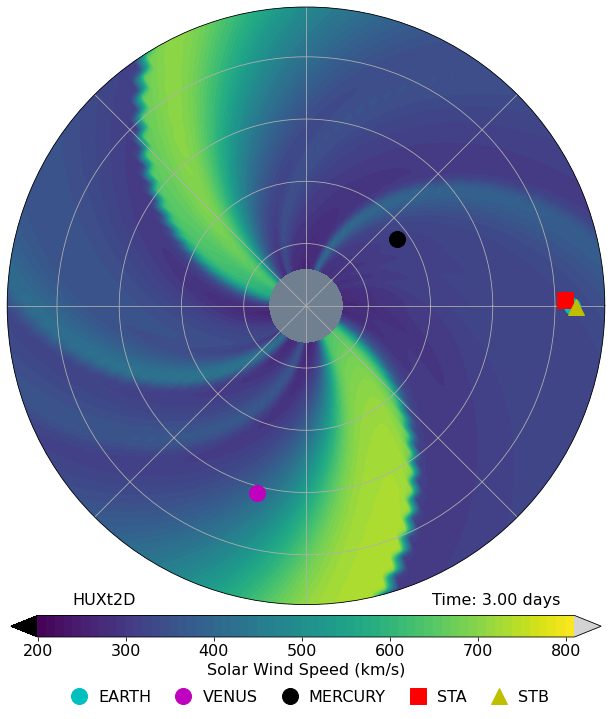

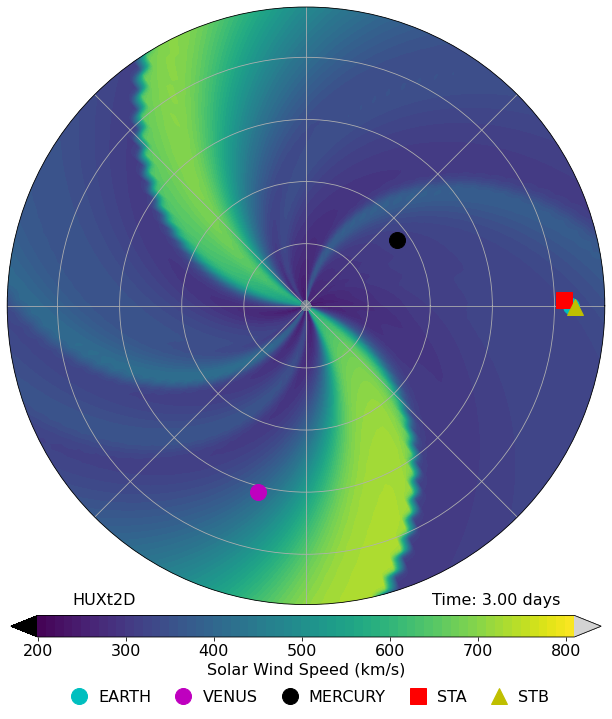

In [17]:
# Setup HUXt for a standard 30Rs run
cr = 2054
vr_in = Hin.get_MAS_long_profile(cr,0.0*u.deg)
#now run HUXt
model = H.HUXt(v_boundary=vr_in, cr_num=cr, latitude=0*u.deg,
               simtime=5*u.day, dt_scale=4)
model.solve([]) 

t_interest=3*u.day
HA.plot(model, t_interest)

#  Map the inner boundary MAS values inwards from 30 rS to 5 rS
vr_5rs = Hin.map_v_boundary_inwards(vr_in, 30*u.solRad, 5*u.solRad)

#  Now setup HUXt to run from 5Rs
model = H.HUXt(v_boundary=vr_5rs, cr_num=cr, simtime=5*u.day, 
               latitude=0*u.deg, dt_scale=4, r_min=5*u.solRad)
model.solve([])

t_interest=3*u.day
HA.plot(model, t_interest)


There is some limited support for running HUXt in 3D. Currently this amounts to a wrapper class, `HUXt3D`, that computes the longitudinal solutions for a range of longitudes. 

In [18]:
#set up a meridional cut run.
cr=2000
vmap, vlats, vlongs = Hin.get_MAS_maps(cr)

model3d=H.HUXt3d(cr_num=cr,v_map=vmap, v_map_lat=vlats, v_map_long=vlongs,
                    latitude_max=90*u.deg, latitude_min=-90*u.deg, lon_out=0.0*u.deg,
                    simtime=3*u.day, r_min=30*u.solRad)

cme = H.ConeCME(t_launch=0.5*u.day, longitude=0.0*u.deg, latitude=0.0*u.deg,
                width=30*u.deg, v=1000*(u.km/u.s), thickness=5*u.solRad)

#run the model
cme_list=[cme]
model3d.solve(cme_list)

#plot the meridional cut
HA.plot_3d_meridional(model3d, 2*u.day, lon=0*u.deg)

#animate the meridional cut
HA.animate_3d(model3d, lon=0*u.deg, tag='model3d')


Files already exist for CR2000


t:   0%|                                                                             | 0/144 [00:00<?, ?it/s, now=None]

Moviepy - Building video C:\Users\yq904481\research\repos\HUXt\figures\HUXt_CR2000_model3d_movie.mp4.
Moviepy - Writing video C:\Users\yq904481\research\repos\HUXt\figures\HUXt_CR2000_model3d_movie.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\yq904481\research\repos\HUXt\figures\HUXt_CR2000_model3d_movie.mp4
